## Import Dependencies

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

In [2]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('Already exists')
else:
  request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open('helper_functions.py',"wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary,plot_predictions

In [3]:
def accuracy_fn(y_true,y_preds):
  correct=torch.eq(y_true,y_preds).sum().item()
  acc=(correct/len(y_preds))*100
  return acc

In [4]:
#Set hyperparameters
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

## Create Data

In [5]:
X_blob,y_blob=make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES,random_state=RANDOM_SEED,cluster_std=1.5)

X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)


### Split the Data

In [6]:
x_train,x_test,y_train,y_test=train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

### Plot the Data

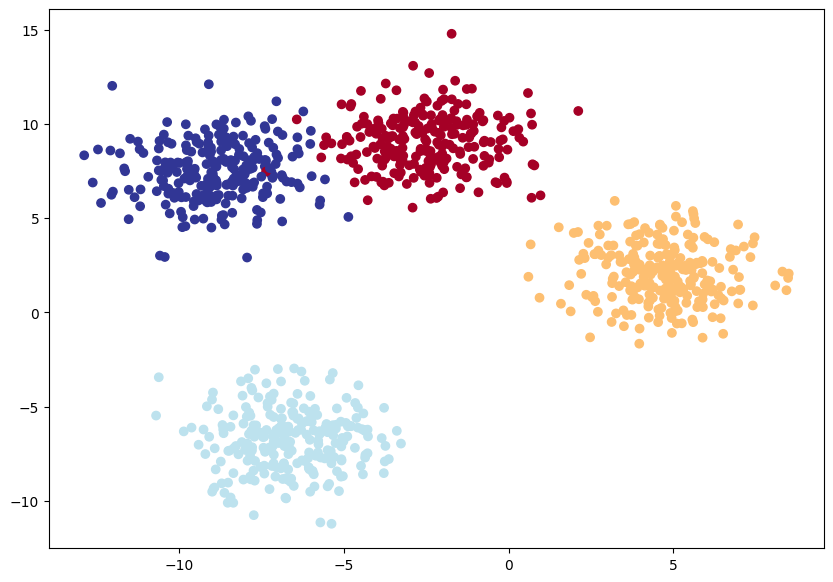

In [7]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

## Model Building

### Device Agnostic Code

In [8]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device:{device}")

Device:cpu


### Building the model

In [9]:
from torch import nn
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_stack=nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self,x):
    return self.linear_stack(x)

#Create instance and send to device
model=BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
model

BlobModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Loss Funtion and Optimizer

In [10]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)

## Training Loop and Testing loop

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100

x_train,y_train=x_train.to(device),y_train.to(device)
x_test,y_test=x_test.to(device),y_test.to(device)

for epoch in range(epochs):
  ###Training Loop
  model.train()

  y_logits=model(x_train)
  y_preds=torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_train,y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ###Testing
  model.eval()
  with torch.inference_mode():
    test_logits=model(x_test)
    test_preds=torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_test,test_preds)

  ###Print Result
  if epoch%10==0:
    print(f"Epoch:{epoch} \nLoss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss:{test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch:0 
Loss: 1.53985 | Accuracy: 37.50% | Test loss:0.93129 | Test Accuracy: 70.00%
Epoch:10 
Loss: 0.19080 | Accuracy: 97.25% | Test loss:0.17547 | Test Accuracy: 99.00%
Epoch:20 
Loss: 0.09368 | Accuracy: 99.12% | Test loss:0.08605 | Test Accuracy: 99.50%
Epoch:30 
Loss: 0.06599 | Accuracy: 99.00% | Test loss:0.05898 | Test Accuracy: 99.50%
Epoch:40 
Loss: 0.05330 | Accuracy: 99.00% | Test loss:0.04608 | Test Accuracy: 99.50%
Epoch:50 
Loss: 0.04618 | Accuracy: 99.00% | Test loss:0.03866 | Test Accuracy: 99.50%
Epoch:60 
Loss: 0.04168 | Accuracy: 99.00% | Test loss:0.03388 | Test Accuracy: 99.50%
Epoch:70 
Loss: 0.03861 | Accuracy: 99.00% | Test loss:0.03056 | Test Accuracy: 99.50%
Epoch:80 
Loss: 0.03640 | Accuracy: 99.00% | Test loss:0.02813 | Test Accuracy: 99.50%
Epoch:90 
Loss: 0.03473 | Accuracy: 99.00% | Test loss:0.02627 | Test Accuracy: 99.50%


## Visualize the Result

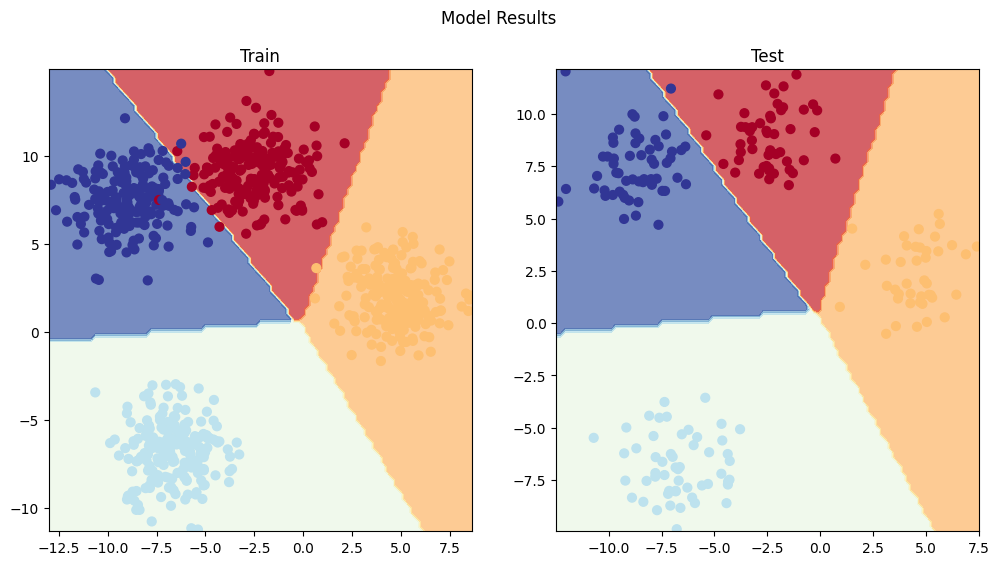

In [12]:
plt.figure(figsize=(12,6))
plt.suptitle("Model Results")
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,x_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model,x_test,y_test)

## Evaluating the Model

* Accuracy
* Precision
* Recall
* F1-Score
* Confusion Matrix
* Classification report

In [27]:
from torchmetrics import Accuracy,ConfusionMatrix,F1Score,Precision,Recall
from sklearn.metrics import classification_report

accuracy=Accuracy(task='multiclass',num_classes=4).to(device)
Accuracy_value=accuracy(test_preds,y_test)

precision=Precision(task='multiclass',num_classes=4).to(device)
precision_value=precision(test_preds,y_test)

recall=Recall(task='multiclass',num_classes=4).to(device)
recall_value=recall(test_preds,y_test)

f1=F1Score(task='multiclass',num_classes=4).to(device)
f1_value=f1(test_preds,y_test)

conf=ConfusionMatrix(task='multiclass',num_classes=4).to(device)
conf_mat=conf(test_preds,y_test)

report=classification_report(test_preds,y_test)

print(f"Accuracy: {Accuracy_value}\nPrecision: {precision_value}\nRecall: {recall_value}\nF-1 Score: {f1_value}\n\nConfusion Matrix : \n{conf_mat}\n\nClassification Report: \n{report}")

Accuracy: 0.9950000047683716
Precision: 0.9950000047683716
Recall: 0.9950000047683716
F-1 Score: 0.9950000047683716

Confusion Matrix : 
tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 1,  0,  0, 56]])

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        53
           3       0.98      1.00      0.99        56

    accuracy                           0.99       200
   macro avg       1.00      0.99      1.00       200
weighted avg       1.00      0.99      0.99       200

